# Exercise 2.3 - Eigenfaces (3.5pts)

<figure>
<a id="examples"><center><img src="imgs/eigenfaces.png" style="width:50%"/></center></a>
<figcaption align = "center"> Figure 1: Some examples of eigenfaces. </figcaption>
</figure>

In this assignment you will compute [eigenfaces](http://engr.case.edu/merat_francis/eecs490f04/References/Face%20Recognition/LD%20Face%20analysis.pdf) of the [Olivetti faces dataset](https://scikit-learn.org/stable/datasets/real_world.html#the-olivetti-faces-dataset). Note that the linked ressources are only here to provide additional background knowledge and you do not need to understand them in any detail to complete this assignment. In general, eigenfaces can be seen as a compressed version of the individual faces in the dataset from which the original faces can be reconstructed. You can find some examples in [Figure 1](#examples). For general datasets, this approach of finding compressed features is also known as Principal Components Analysis (PCA), which will be covered in detail in upcoming lectures. To complete this assignment, however, the material covered up to Chapter 3 is sufficient. 

In [16]:
import sys
assert sys.version_info >= (3, 6), "This notebook requires python version >= 3.6 to support type hints."

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

In [18]:
def plot_faces(imgs: np.ndarray, n: int) -> None:
    """Plots the first n images from imgs
    args:
        imgs: a numpy array of shape (N, 64, 64) containing N 64x64 images
        n: number of images to plot
    """
    assert imgs.shape[0] >= n, f"imgs array must contain at least {n} images"
    assert imgs.ndim == 3, f"imgs array must be of shape (N, H, W)"
    assert imgs.shape[1:] == (64, 64), f"Images must be of dimension (64, 64) not {imgs.shape[1:]}. If you passed flattened images, reshape them first."
    fig, axes = plt.subplots(1, n)
    if n > 1: # Added this to make it able to plot 1 face
        for i in range(n):
            axes[i].imshow(imgs[i])
            axes[i].set_axis_off()
    else:
        assert n == 1, "n must be at least 1"
        axes.imshow(imgs[0])
    plt.show()

The faces are stored as a numpy array and are loaded by executing the cell below. Make sure to place the file `faces.npy` that comes with the assignment in the same folder as this notebook.

In [19]:
faces = np.load('faces.npy')
faces.shape

(400, 64, 64)

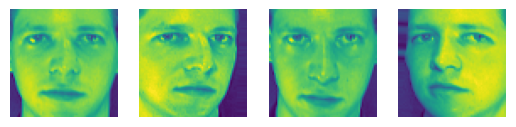

In [20]:
plot_faces(faces, 4)

## Exercise 2.3.1 - Preprocess (0.5pts)
First, calculate the average of all the face images in the dataset to find the mean face. Then, adjust each image in the dataset by subtracting this mean face from it, effectively centering the dataset. For reference, the mean face should look as in [Figure 2](#meanface). Lastly, flatten each image into a vector. After preprocessing, your dataset should contain 400 4096-dimensional vectors.

<figure>
<a id="examples"><center><img src="imgs/meanface.png" style="width:15%"/></center></a>
<figcaption align = "center"> Figure 2: Mean face. </figcaption>
</figure>

In [21]:
def preprocess(faces: np.ndarray) -> np.ndarray:
    """Reshapes each face image into a 1D vector and column-centers them to have mean 0."""  
    # flatten each image to 1d
    faces_reshaped = faces.reshape((faces.shape[0], -1))
    # calculate mean
    mean = np.mean(faces_reshaped, axis=0)
    # plot_faces(mean.reshape(1, 64, 64), 1) For debugging
    # substract (center)
    centered = faces_reshaped - mean

    assert centered.shape == (faces.shape[0], faces.shape[1] * faces.shape[2])
    return centered

faces_1d = preprocess(faces)

## Exercise 2.3.2 - EVD (1pt)
Compute the covariance matrix of the preprocessed faces using the formula $\text{Var}[\boldsymbol{X}] = \frac{1}{m - 1} \boldsymbol{X}^T \boldsymbol{X}$, where $\boldsymbol{X} \in \mathbb{R}^{m\times n}$. Afterwards, find its eigenvectors ordered in descending order by their corresponding eigenvalues. You can use `sort_eigvectors` to do the sorting. Afterwards, plot the first four eigenfaces.

**Note:** If you use numpy, you will need to use `np.linalg.eigh` instead of `np.linalg.eig` to compute the eigendecomposition to avoid running into numerical issues. 

In [22]:
def sort_eigvectors(eigvalues: np.ndarray, eigvectors: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Sorts eigenvectors according to their corresponding eigenvalues. The input is expected to be the result of np.linalg.eigh.""" 
    idx = eigvalues.argsort()[::-1]
    eigvalues = eigvalues[idx] 
    eigvectors = eigvectors[:, idx]
    return eigvalues, eigvectors

In [23]:
def eigenfaces_evd(face_vectors: np.ndarray) -> np.ndarray:
    cov = (1 / (face_vectors.shape[0] - 1)) * (np.transpose(face_vectors) @ face_vectors)
    eigvals, eigvecs = np.linalg.eigh(cov)
    # Since np.linalg.eigh returns eigenvectors in columns, that is eigvecs[:, i]
    # is one eigenvector
    _, sorted_eigvecs = sort_eigvectors(eigvals, eigvecs)
    return sorted_eigvecs

eigenfaces_unshaped = eigenfaces_evd(faces_1d) # This returns (4096, 4096)

In [24]:
def eigenfaces_plot(eigen_vectors: np.ndarray) -> None:
    first4 = eigen_vectors[:,:4]
    first4_transpose = first4.transpose()
    first4_transpose_reshape = first4_transpose.reshape((first4_transpose.shape[0], 64, 64))
    plot_faces(first4_transpose_reshape, 4)

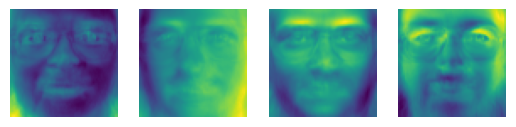

In [25]:
eigenfaces_plot(eigenfaces_unshaped)

## Exercise 2.3.3 - SVD (0.5pt)
Eigenfaces can also be computed using a singular value decomposition of the data matrix. Complete `eigenfaces_svd` by computing a singular value decomposition and returning the right singular values of the data matrix. Again, plot the first four eigenfaces.

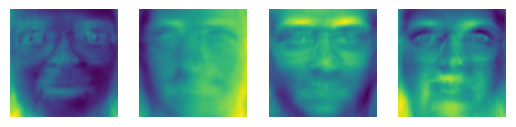

In [26]:
def eigenfaces_svd(face_vectors: np.ndarray) -> np.ndarray:
    U, S, Vh = np.linalg.svd(face_vectors)
    # According to the documentation, S values are already sorted in descending
    # order, https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
    # And Vh is already transposed
    return U, S, Vh

_, _, eigenfaces_with_svd = eigenfaces_svd(faces_1d)
plot_faces(eigenfaces_with_svd.reshape((-1, 64, 64)), 4)

**Note**: The brightness values for some images might be inverted compared to the examples in [Figure 1](#examples) or those computed using the EVD. This is due to different algorithms used under the hood and you don't need to worry about it.

## Exercise 2.3.4 - Reconstruction (1pt)
Reconstruct the faces in the dataset with varying levels of accuracy. Use the SVD for this and vary the accuracy by including more or fewer singular values. You can do this by setting more or fewer singular values inside the diagonal matrix $\boldsymbol{D}$ to zero. Plot the first four faces in the dataset once using 25 singular values  and once using 200 singular values.

In [27]:
def reconstruct(faces: np.ndarray, num_singular_values: int) -> np.ndarray:
    U, D, Vh = eigenfaces_svd(faces)
    D[num_singular_values : ] = 0
    m, n = faces.shape
    if m == n:
        faces_reconstructed = U @ np.diag(D) @ V
    else:
        # # Since faces is not rectangular, U @ np.diag(D) @ V does not work
        # https://stackoverflow.com/questions/24913232/using-numpy-np-linalg-svd-for-singular-value-decomposition
        faces_reconstructed = U[:,:n] @ np.diag(D) @ Vh[:m,:] 
    return faces_reconstructed

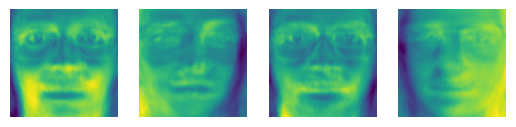

In [28]:
# With 25 singular values
faces_25 = reconstruct(faces_1d, 25)
plot_faces(faces_25.reshape(-1, 64, 64), 4)

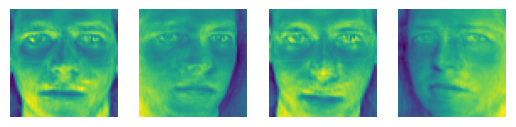

In [29]:
# With 200 singular values
faces_200 = reconstruct(faces_1d, 200)
plot_faces(faces_200.reshape(-1, 64, 64), 4)

In [30]:
print(faces_1d.shape)

(400, 4096)


## Exercise 2.3.5 - Quiz (0.5pts)
1. Why are the results of exercise 2.3.2 and 2.3.3 the same?
2. (Optional) You may have noticed that the computation using the singular value decomposition was much faster than the eigenvalue decomposition.
   Why is this the case?

### Solution (1st Question) 
1. The reason why we get the same results for 2.3.2 and 2.3.3, is because of the following:

    a. We subtracted the mean from the original images. That is, $\boldsymbol{X} = \boldsymbol{F} - \boldsymbol{\bar{F}}$.

    b. We performed the eigenvalue decomposition on the covariance matrix $\text{Var}[\boldsymbol{X}] = \frac{1}{m - 1} \boldsymbol{X}^T \boldsymbol{X}$, where $\boldsymbol{X} \in \mathbb{R}^{m\times n}$. Note that $\boldsymbol{X}$ is the faces vectors with its mean subtracted. 

    c. Thanks to a. and b., we obtained a covariance matrix. This matrix is symmetric.
    
    d. The SVD was computed on $\boldsymbol{X}$, where again we have already subtracted the mean.

Now, when we perform Eigenvalue Decomposition on a symmetric matrix, such as the covariance matrix, let's call it $\boldsymbol{A}$. Then $\boldsymbol{A} = \boldsymbol{Q}\Lambda \boldsymbol{Q}^T$, where $\boldsymbol{Q}$ is orthogonal and its columns are the eigenvectors, and $\boldsymbol{\Lambda}$ is a matrix with eigenvalues on the diagonal. 

On the other hand, for any matrix $\boldsymbol{A}$, including symmetric matrices, we can decompose it as $\boldsymbol{A} = \boldsymbol{U} \boldsymbol{D} \boldsymbol{V}^T$, where $\boldsymbol{U}$ and $\boldsymbol{V}$ are orthogonal matrices and their columns are the left and right singular vectors, respectively, and $\boldsymbol{D}$ is a diagonal matrix with singular values on the diagonal.

From that, we can see that on symmetric matrices, Eigenvalue Decomposition is just a special case of SVD, where $\boldsymbol{U} = \boldsymbol{V}$. Therefore, the eigenvectors obtained from the Eigenvalue Decomposition are equivalent to the right singular vectors obtained from SVD. Consequently, it is fair to consider that the algorithms that numpy is using to solve each problem will reach the same result, since they are equivalent on symmetric matrices. 

Physically, what this means, is that the vectors obtained from both mathematical processes are the same. These vectors best represent the original data in less dimensions. In the context of Eigenvalue Decomposition, these are the eigenvectors and they represent the directions in space that are most representative in the data. And this is also what SVD does, finding the singular values that when multiplied by the vector columns in $\boldsymbol{D}$ reconstruct the original data the closest.